In [2]:

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.preprocessing import normalize, MinMaxScaler
from tqdm import tqdm

from deepface import DeepFace

from lightphe import LightPHE

try:
    import tenseal as ts
    TENSEAL_AVAILABLE = True
except ImportError:
    print("TenSEAL not available. Please install with: pip install tenseal")
    TENSEAL_AVAILABLE = False

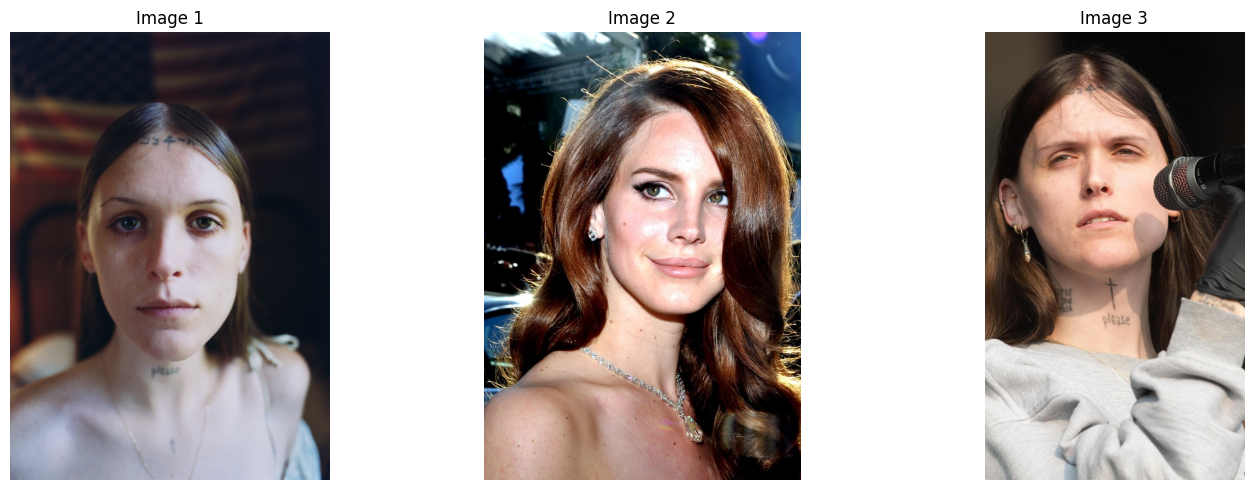

In [3]:
# Cell 2: Setup directories and images
os.makedirs("test_images", exist_ok=True)
os.makedirs("keys", exist_ok=True)

# Helper function to download sample images
def download_sample_images():
    import requests
    
    image_urls = {
        "img1.jpg": "https://scontent.fdad3-1.fna.fbcdn.net/v/t51.75761-15/472904288_18479691505008747_5108622755100274801_n.jpg?stp=dst-jpg_s1080x2048_tt6&_nc_cat=108&ccb=1-7&_nc_sid=127cfc&_nc_ohc=CK5R9XS6rcQQ7kNvwH6nP__&_nc_oc=AdlJRamIM99qE_yRF4sbD8pdEVbmZNIDCUIQbToQHNauRiu932tzSHqpULJvYjqeyuI&_nc_zt=23&_nc_ht=scontent.fdad3-1.fna&_nc_gid=CMqsoC0d4vvPpm5Sa73x-w&oh=00_AfMKoRMzuVw5BbU9A_SGbJCs2SUDe5OsKw7uCCbhEuM04Q&oe=6866DF80",
        "img2.jpg": "https://upload.wikimedia.org/wikipedia/commons/7/71/Lana_Del_Rey_Cannes_2012.jpg",
        "img3.jpg": "https://seatgeekimages.com/performers-landscape/ethel-cain-2c11be/798453/1100x1900.jpg?auto=webp&width=3840&quality=75"
    }
    
    for filename, url in image_urls.items():
        filepath = os.path.join("test_images", filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {filename}")

download_sample_images()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_file in enumerate(["img1.jpg", "img2.jpg", "img3.jpg"]):
    img_path = os.path.join("test_images", img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [78]:
# Cell for TenSEAL Benchmark Sweep (with Client-Server Context Separation and Base64 I/O)
import pandas as pd
import numpy as np
import time
import pickle
import os
import sys # For sys.getsizeof
import json # Import json to save results
import base64 # Import base64 for encoding/decoding binary data

# Ensure tenseal is imported and available
try:
    import tenseal as ts
    TENSEAL_AVAILABLE = True
except ImportError:
    TENSEAL_AVAILABLE = False
    print("TenSEAL is not installed. Please install it with 'pip install tenseal'")
    sys.exit("Exiting because TenSEAL is not available.") # Exit if TenSEAL is critical

# Ensure DeepFace is imported (assuming it's installed)
try:
    from deepface import DeepFace
except ImportError:
    print("DeepFace is not installed. Please install it with 'pip install deepface'")
    sys.exit("Exiting because DeepFace is not available.")


# --- User-provided helper functions for reading/writing serialized context/ciphertexts ---
def write_data(file_name, data):
    """Writes bytes data to a file, encoding to base64 if necessary."""
    if isinstance(data, bytes): # Use isinstance for robust type checking
        # bytes to base64 bytes
        data = base64.b64encode(data)
        
    with open(file_name, 'wb') as f: # Open in binary write mode
        f.write(data)

def read_data(file_name):
    """Reads base64 encoded data from a file and decodes to bytes."""
    with open(file_name, "rb") as f: # Open in binary read mode
        data = f.read()
    
    # base64 to bytes
    return base64.b64decode(data)


# Function to calculate cosine similarity (retained)
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)

# MODIFIED: get_object_size_in_mb to directly measure Base64 string size
def get_object_size_in_mb(data_bytes_base64_encoded):
    """Calculates the size of Base64 encoded bytes object in MB."""
    # sys.getsizeof() gets the size of the bytes object in memory.
    # This will directly correspond to the size of the Base64 encoded data as stored in the file.
    return sys.getsizeof(data_bytes_base64_encoded) / (1024 * 1024)

print("Testing face recognition using VGG-Face with TenSEAL FHE")
print("-" * 60)

IMG_DIR = "test_images"
KEYS_DIR = "keys"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(KEYS_DIR, exist_ok=True)

# --- Extract embeddings once (plaintext baseline) ---
print(f"Extracting VGG-Face embeddings...")
try:
    start_time = time.time()
    # Ensure enforce_detection=True is used to avoid errors if no face is found
    ethel1_embedding = np.array(DeepFace.represent(os.path.join(IMG_DIR, "img1.jpg"), 
                                        model_name="VGG-Face", detector_backend="yunet", enforce_detection=True)[0]["embedding"])
    ethel2_embedding = np.array(DeepFace.represent(os.path.join(IMG_DIR, "img3.jpg"), 
                                        model_name="VGG-Face", detector_backend="yunet", enforce_detection=True)[0]["embedding"])
    lana_embedding = np.array(DeepFace.represent(os.path.join(IMG_DIR, "img2.jpg"), 
                                      model_name="VGG-Face", detector_backend="yunet", enforce_detection=True)[0]["embedding"])
    extract_time = time.time() - start_time
    
    print(f"VGG-Face embeddings extracted in {extract_time:.4f} seconds")
    print(f"Embedding dimensions: {len(ethel1_embedding)}")
    
    expected_cos_ethel1_ethel2 = cosine_similarity(ethel1_embedding, ethel2_embedding)
    expected_cos_ethel1_lana = cosine_similarity(ethel1_embedding, lana_embedding)
    
    print(f"Expected cosine similarity (Ethel1-Ethel2): {expected_cos_ethel1_ethel2:.6f}")
    print(f"Expected cosine similarity (Ethel1-Lana): {expected_cos_ethel1_lana:.6f}")

except Exception as e:
    print(f"Error extracting embeddings: {e}")
    sys.exit("Exiting because embeddings could not be extracted.") # Exit if critical

# --- Define TenSEAL Parameters to Sweep ---
poly_modulus_degrees = [8192, 16384]

# RESTORED: Full coeff_mod_bit_sizes_configs as originally provided
coeff_mod_bit_sizes_configs = {
    8192: { 
        "q=200_4levels": [60, 40, 40, 60], 
        "q=160_3levels": [60, 40, 60]      
    },
    16384: { 
        "q=420_7levels": [60, 50, 50, 50, 50, 50, 50, 60], 
        "q=280_5levels": [60, 40, 40, 40, 40, 60],
        "q=200_4levels": [60, 40, 40, 60], 
        "q=160_3levels": [60, 40, 60]      
    }
}

global_scale_options = [2**40] 

all_benchmark_results = []

if not TENSEAL_AVAILABLE:
    print("TenSEAL is not available, skipping FHE benchmark.")
else:
    for poly_deg in poly_modulus_degrees:
        if poly_deg not in coeff_mod_bit_sizes_configs:
            print(f"Warning: No coeff_mod_bit_sizes defined for poly_mod_degree={poly_deg}. Skipping.")
            continue

        for q_label, coeff_bits in coeff_mod_bit_sizes_configs[poly_deg].items():
            for g_scale in global_scale_options:
                print(f"\n===== Benchmarking TenSEAL with Poly Mod Deg={poly_deg}, Coeff Mod Bits={q_label}, Global Scale={g_scale} =====")
                
                current_result = {
                    "Scheme": "CKKS",
                    "Poly Modulus Degree (p)": poly_deg,
                    "Coeff Mod Bit Sizes (q_label)": q_label,
                    "Actual Coeff Mod Bit Sizes": coeff_bits,
                    "Global Scale": g_scale,
                    "Encryption Time (s)": "N/A",
                    "Dot Product Time (s)": "N/A",
                    "Decryption Time (s)": "N/A",
                    "Total FHE Time (s)": "N/A",
                    "Ciphertext Size (MB/emb)": "N/A",
                    "Secret Context Size (MB)": "N/A", 
                    "Public Context Size (MB)": "N/A",  
                    "FHE Ethel1-Ethel2": "N/A",
                    "Error Ethel1-Ethel2": "N/A",
                    "FHE Ethel1-Lana": "N/A",
                    "Error Ethel1-Lana": "N/A",
                    "Error": None
                }

                try:
                    # --- Context Generation and Key Separation ---
                    context_base_filename = f"tenseal_context_p{poly_deg}_q{q_label.replace('=', '').replace(' ', '')}_scale{g_scale}"
                    secret_context_path = os.path.join(KEYS_DIR, f"{context_base_filename}_secret.txt") 
                    public_context_path = os.path.join(KEYS_DIR, f"{context_base_filename}_public.txt") 

                    secret_context_bytes_encoded = None
                    public_context_bytes_encoded = None

                    # If files exist, load their *encoded* content to measure size.
                    # Otherwise, generate and then measure their *encoded* size before saving.
                    if os.path.exists(secret_context_path) and os.path.exists(public_context_path):
                        print(f"Contexts already exist for {q_label}. Loading...")
                        # We need the raw Base64 content to measure its size using sys.getsizeof
                        with open(secret_context_path, "rb") as f:
                            secret_context_bytes_encoded = f.read()
                        with open(public_context_path, "rb") as f:
                            public_context_bytes_encoded = f.read()

                        current_result["Secret Context Size (MB)"] = get_object_size_in_mb(secret_context_bytes_encoded)
                        current_result["Public Context Size (MB)"] = get_object_size_in_mb(public_context_bytes_encoded)
                        
                    else:
                        print(f"Generating new TenSEAL context for p={poly_deg}, q_label={q_label}, scale={g_scale}...")
                        full_context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=poly_deg, coeff_mod_bit_sizes=coeff_bits)
                        full_context.global_scale = g_scale
                        full_context.generate_galois_keys()
                        full_context.generate_relin_keys() 

                        # Serialize secret context (raw bytes)
                        secret_context_raw_bytes = full_context.serialize(save_secret_key=True)
                        write_data(secret_context_path, secret_context_raw_bytes)
                        # Read the *written* (Base64 encoded) file to measure its actual size on disk
                        with open(secret_context_path, "rb") as f:
                            secret_context_bytes_encoded = f.read()
                        print(f"Secret context saved to {secret_context_path}")

                        # Create public-only context from the raw secret context bytes for serialization
                        public_only_context_for_serialization = ts.context_from(secret_context_raw_bytes) 
                        public_only_context_for_serialization.make_context_public() 
                        public_context_raw_bytes = public_only_context_for_serialization.serialize()
                        write_data(public_context_path, public_context_raw_bytes)
                        # Read the *written* (Base64 encoded) file to measure its actual size on disk
                        with open(public_context_path, "rb") as f:
                            public_context_bytes_encoded = f.read()
                        print(f"Public context saved to {public_context_path}")
                        
                        current_result["Secret Context Size (MB)"] = get_object_size_in_mb(secret_context_bytes_encoded)
                        current_result["Public Context Size (MB)"] = get_object_size_in_mb(public_context_bytes_encoded)

                        del full_context, public_only_context_for_serialization, secret_context_raw_bytes, public_context_raw_bytes # Clean up


                    # --- Encryption (Client Side Simulation) ---
                    # Client loads the secret context to encrypt
                    # Note: read_data returns decoded bytes, so ts.context_from needs decoded bytes
                    client_context = ts.context_from(read_data(secret_context_path))
                    start_time = time.time()
                    ethel1_fhe = ts.ckks_vector(client_context, ethel1_embedding.tolist()) # Ensure list conversion
                    ethel2_fhe = ts.ckks_vector(client_context, ethel2_embedding.tolist()) # Ensure list conversion
                    lana_fhe = ts.ckks_vector(client_context, lana_embedding.tolist())   # Ensure list conversion
                    fhe_enc_time = time.time() - start_time
                    current_result["Encryption Time (s)"] = fhe_enc_time / 3 

                    # Measure ciphertext size (this will be the Base64 encoded size on disk)
                    current_result["Ciphertext Size (MB/emb)"] = get_object_size_in_mb(base64.b64encode(ethel1_fhe.serialize()))
                    
                    # Serialize encrypted embeddings to simulate sending to server (raw bytes)
                    ethel1_fhe_serialized_raw = ethel1_fhe.serialize()
                    ethel2_fhe_serialized_raw = ethel2_fhe.serialize()
                    lana_fhe_serialized_raw = lana_fhe.serialize()

                    # Clean up client_context and client-side encrypted vectors to simulate transfer
                    del client_context
                    del ethel1_fhe, ethel2_fhe, lana_fhe


                    # --- Computation (Server Side Simulation) ---
                    # Server loads the public context to compute on encrypted data
                    server_context = ts.context_from(read_data(public_context_path))
                    
                    # Server deserializes received encrypted embeddings (raw bytes)
                    server_ethel1_fhe = ts.ckks_vector_from(server_context, ethel1_fhe_serialized_raw)
                    server_ethel2_fhe = ts.ckks_vector_from(server_context, ethel2_fhe_serialized_raw)
                    server_lana_fhe = ts.ckks_vector_from(server_context, lana_fhe_serialized_raw)

                    start_time = time.time()
                    fhe_dot_ethel1_ethel2 = server_ethel1_fhe.dot(server_ethel2_fhe)
                    fhe_dot_ethel1_lana = server_ethel1_fhe.dot(server_lana_fhe)
                    fhe_dot_time = time.time() - start_time
                    current_result["Dot Product Time (s)"] = fhe_dot_time / 2 

                    # Serialize results to simulate sending back to client (raw bytes)
                    fhe_dot_ethel1_ethel2_serialized_raw = fhe_dot_ethel1_ethel2.serialize()
                    fhe_dot_ethel1_lana_serialized_raw = fhe_dot_ethel1_lana.serialize()

                    # Clean up server_context and server-side encrypted vectors
                    del server_context
                    del server_ethel1_fhe, server_ethel2_fhe, server_lana_fhe
                    del fhe_dot_ethel1_ethel2, fhe_dot_ethel1_lana


                    # --- Decryption (Client Side Simulation) ---
                    # Client loads the secret context to decrypt
                    client_context_dec = ts.context_from(read_data(secret_context_path))
                    
                    # Client deserializes received encrypted results (raw bytes)
                    fhe_dot_ethel1_ethel2_dec_vec = ts.lazy_ckks_vector_from(fhe_dot_ethel1_ethel2_serialized_raw)
                    fhe_dot_ethel1_lana_dec_vec = ts.lazy_ckks_vector_from(fhe_dot_ethel1_lana_serialized_raw)
                    
                    # Bind the vectors to the client_context_dec for decryption
                    fhe_dot_ethel1_ethel2_dec_vec.link_context(client_context_dec)
                    fhe_dot_ethel1_lana_dec_vec.link_context(client_context_dec)

                    start_time = time.time()
                    fhe_dot_ethel1_ethel2_dec = fhe_dot_ethel1_ethel2_dec_vec.decrypt()[0]
                    fhe_dot_ethel1_lana_dec = fhe_dot_ethel1_lana_dec_vec.decrypt()[0]
                    fhe_dec_time = time.time() - start_time
                    current_result["Decryption Time (s)"] = fhe_dec_time / 2 

                    # Clean up decryption context
                    del client_context_dec
                    del fhe_dot_ethel1_ethel2_dec_vec, fhe_dot_ethel1_lana_dec_vec


                    current_result["Total FHE Time (s)"] = current_result["Encryption Time (s)"] + current_result["Dot Product Time (s)"] + current_result["Decryption Time (s)"]
                    

                    
                    current_result["FHE Ethel1-Ethel2"] = fhe_dot_ethel1_ethel2_dec
                    current_result["Error Ethel1-Ethel2"] = abs(fhe_dot_ethel1_ethel2_dec - expected_cos_ethel1_ethel2)
                    current_result["FHE Ethel1-Lana"] = fhe_dot_ethel1_lana_dec
                    current_result["Error Ethel1-Lana"] = abs(fhe_dot_ethel1_lana_dec - expected_cos_ethel1_lana)

                except Exception as e:
                    print(f"Error during TenSEAL benchmark for p={poly_deg}, q_label={q_label}, scale={g_scale}: {e}")
                    current_result["Error"] = str(e)
                finally:
                    all_benchmark_results.append(current_result)

# Save all results to a JSON file
tenseal_results_file = "tenseal_benchmark_results.json"
try:
    with open(tenseal_results_file, 'w') as f:
        json.dump(all_benchmark_results, f, indent=4)
    print(f"\nAll TenSEAL benchmark results saved to {tenseal_results_file}")
except Exception as e:
    print(f"Error saving TenSEAL results to JSON: {e}")

try:
    import pandas as pd
    df_tenseal = pd.DataFrame(all_benchmark_results)
    print("\n--- TenSEAL Benchmark Results DataFrame ---")
    print(df_tenseal)
except ImportError:
    print("\nInstall pandas (pip install pandas) for better results visualization.")

Testing face recognition using VGG-Face with TenSEAL FHE
------------------------------------------------------------
Extracting VGG-Face embeddings...
VGG-Face embeddings extracted in 1.2689 seconds
Embedding dimensions: 4096
Expected cosine similarity (Ethel1-Ethel2): 0.539833
Expected cosine similarity (Ethel1-Lana): 0.115143

===== Benchmarking TenSEAL with Poly Mod Deg=8192, Coeff Mod Bits=q=200_4levels, Global Scale=1099511627776 =====
Contexts already exist for q=200_4levels. Loading...

===== Benchmarking TenSEAL with Poly Mod Deg=8192, Coeff Mod Bits=q=160_3levels, Global Scale=1099511627776 =====
Contexts already exist for q=160_3levels. Loading...

===== Benchmarking TenSEAL with Poly Mod Deg=16384, Coeff Mod Bits=q=420_7levels, Global Scale=1099511627776 =====
Contexts already exist for q=420_7levels. Loading...

===== Benchmarking TenSEAL with Poly Mod Deg=16384, Coeff Mod Bits=q=280_5levels, Global Scale=1099511627776 =====
Contexts already exist for q=280_5levels. Loadin

In [80]:
import pandas as pd
import json
import plotly.graph_objects as go
import sys

# Load the JSON data
# Ensure 'tenseal_benchmark_results.json' is in the same directory as this script,
# or provide the full path to the file.
try:
    with open('tenseal_benchmark_results.json', 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Error loading tenseal_benchmark_results.json: {e}")
    sys.exit("Exiting because data could not be loaded.")

# Filter out rows with errors (if any were recorded in the 'Error' column)
df_filtered = df[df['Error'].isnull()].copy()

if df_filtered.empty:
    print("No valid benchmark results found after filtering errors.")
else:
    # Select and reorder relevant columns for the table
    selected_columns = [
        "Poly Modulus Degree (p)",
        "Coeff Mod Bit Sizes (q_label)",
        "Global Scale",
        "Encryption Time (s)",
        "Dot Product Time (s)",
        "Decryption Time (s)",
        "Total FHE Time (s)",
        "Ciphertext Size (MB/emb)",
        "Secret Context Size (MB)",
        "Public Context Size (MB)",
        "FHE Ethel1-Ethel2",
        "Error Ethel1-Ethel2",
        "FHE Ethel1-Lana",
        "Error Ethel1-Lana"
    ]
    
    # Ensure all selected columns exist in the DataFrame
    missing_columns = [col for col in selected_columns if col not in df_filtered.columns]
    if missing_columns:
        print(f"Warning: The following columns are missing from the data and will be excluded: {missing_columns}")
        selected_columns = [col for col in selected_columns if col not in missing_columns]

    df_table_data = df_filtered[selected_columns].copy()

    # Sort the DataFrame for better readability, first by Poly Modulus Degree, then by Coeff Mod Bit Sizes
    df_table_data['Poly Modulus Degree (p)'] = df_table_data['Poly Modulus Degree (p)'].astype(str)
    df_table_data = df_table_data.sort_values(by=['Poly Modulus Degree (p)', 'Coeff Mod Bit Sizes (q_label)'])

    # Format numerical columns for better readability, e.g., to 6 decimal places
    for col in df_table_data.columns:
        if df_table_data[col].dtype == 'float64':
            df_table_data[col] = df_table_data[col].round(6) # Adjust precision as needed

    # Create Plotly Table
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_table_data.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df_table_data[col] for col in df_table_data.columns],
                   fill_color='lavender',
                   align='left'))
    ])

    fig.update_layout(title_text="TenSEAL Benchmark Results Table", title_x=0.5)
    fig.show()
    # Save the Plotly table as a JSON file
    output_filename = "tenseal_benchmark_table.json"
    fig.write_json(output_filename)
    print(f"Plotly table saved to {output_filename}")

Plotly table saved to tenseal_benchmark_table.json


Initializing webcam...
Capturing in 3 seconds... Look at the camera
3...
2...
1...
Smile!
Image saved to test_images/webcam_capture.jpg

Processing your face image...


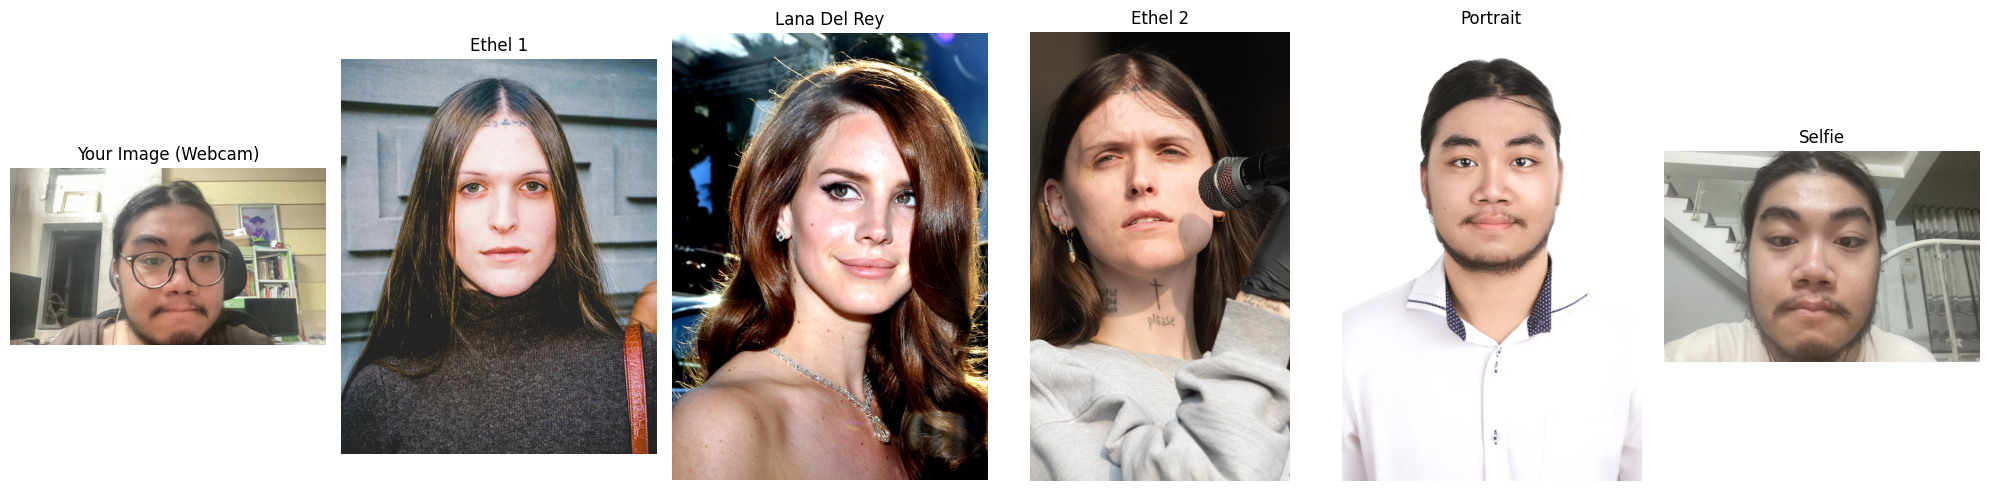


Extracting face embeddings...


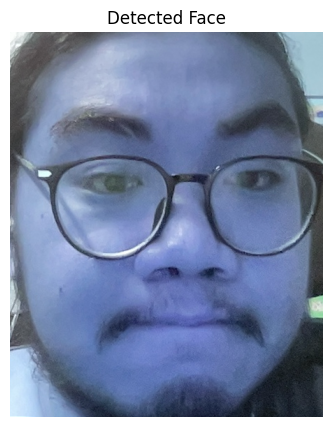

Successfully extracted embedding for Ethel 1
Successfully extracted embedding for Lana Del Rey
Successfully extracted embedding for Ethel 2
Successfully extracted embedding for Portrait
Successfully extracted embedding for Selfie
Face embedding extracted. Shape: (512,)

Plaintext cosine similarities:
You and Ethel 1: -0.3244
You and Lana Del Rey: 0.0228
You and Ethel 2: -0.0703
You and Portrait: 0.7852
You and Selfie: 0.8758

Encrypting your face embedding with TenSEAL...
Encryption complete in 0.0039 seconds!

Comparing with reference faces using FHE...
FHE Similarity with Ethel 1: -0.3244 (dot product time: 0.0115s, decrypt time: 0.0007s)
FHE Similarity with Lana Del Rey: 0.0228 (dot product time: 0.0083s, decrypt time: 0.0005s)
FHE Similarity with Ethel 2: -0.0703 (dot product time: 0.0082s, decrypt time: 0.0005s)
FHE Similarity with Portrait: 0.7852 (dot product time: 0.0083s, decrypt time: 0.0005s)
FHE Similarity with Selfie: 0.8758 (dot product time: 0.0082s, decrypt time: 0.0005

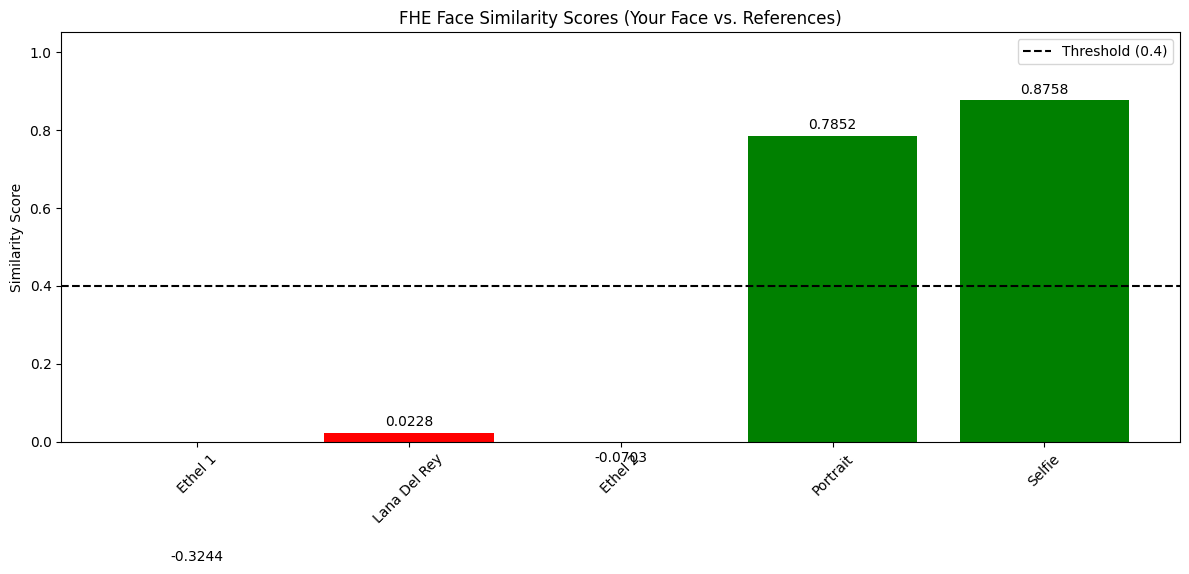


FHE vs Plaintext Comparison:
           name  fhe_similarity  plaintext_similarity         error
0       Ethel 1       -0.324399             -0.324399  4.532632e-08
1  Lana Del Rey        0.022784              0.022784  1.453867e-09
2       Ethel 2       -0.070349             -0.070349  1.088627e-08
3      Portrait        0.785183              0.785183  1.032707e-07
4        Selfie        0.875771              0.875771  1.161552e-07


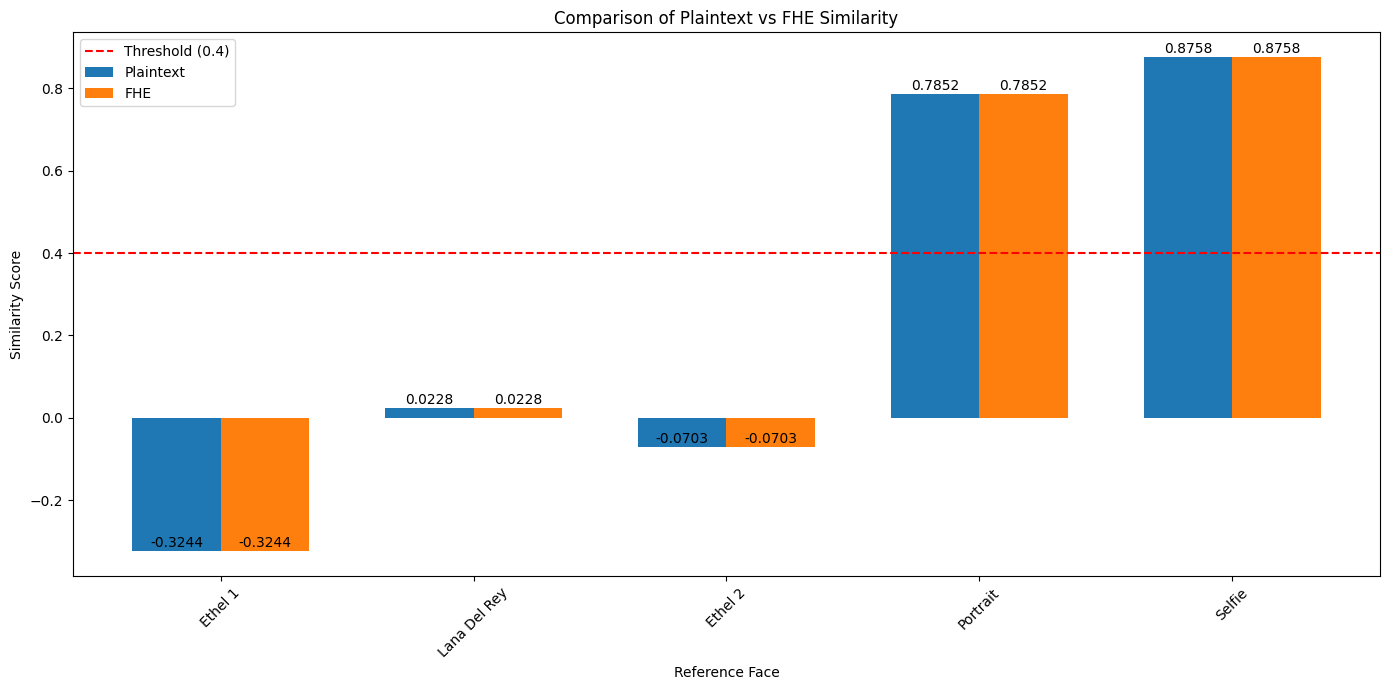


Match Summary (Sorted by FHE Score):
      Reference  Plaintext Score  FHE Score Match Status  Processing Time (s)
4        Selfie         0.875771   0.875771        MATCH             0.008756
3      Portrait         0.785183   0.785183        MATCH             0.008767
1  Lana Del Rey         0.022784   0.022784     NO MATCH             0.008814
2       Ethel 2        -0.070349  -0.070349     NO MATCH             0.008727
0       Ethel 1        -0.324399  -0.324399     NO MATCH             0.012168


In [13]:
# Cell 6: Webcam Face Verification with TenSEAL FHE (Fixed)
import cv2
import time
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def capture_from_webcam():
    """Capture an image from webcam and save it to test_images folder"""
    # Initialize webcam
    print("Initializing webcam...")
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None
    
    # Create preview window
    cv2.namedWindow("Webcam Preview", cv2.WINDOW_NORMAL)
    
    # Wait for camera to initialize
    time.sleep(1)
    
    countdown_seconds = 3
    captured_frame = None
    
    print(f"Capturing in {countdown_seconds} seconds... Look at the camera")
    
    # Countdown loop
    for i in range(countdown_seconds, 0, -1):
        print(f"{i}...")
        
        # Capture frames during countdown
        for _ in range(10):  # Show multiple frames during each countdown second
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                cap.release()
                cv2.destroyAllWindows()
                return None
                
            # Display countdown on frame - but don't modify the original frame
            display_frame = frame.copy()
            cv2.putText(display_frame, str(i), (display_frame.shape[1]//2 - 50, display_frame.shape[0]//2 + 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 4)
            cv2.imshow("Webcam Preview", display_frame)
            cv2.waitKey(100)  # Small delay
    
    # Capture the final frame
    print("Smile!")
    ret, frame = cap.read()
    
    if ret:
        captured_frame = frame.copy()  # Store the clean frame without any text
        
        # Show "Captured!" message on display frame only
        display_frame = frame.copy()
        cv2.putText(display_frame, "Captured!", (display_frame.shape[1]//2 - 100, display_frame.shape[0]//2 + 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        cv2.imshow("Webcam Preview", display_frame)
        cv2.waitKey(1000)  # Show for 1 second
        
        # Save the clean image without any text
        img_path = os.path.join("test_images", "webcam_capture.jpg")
        cv2.imwrite(img_path, captured_frame)
        print(f"Image saved to {img_path}")
    else:
        print("Error: Failed to capture frame.")
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    return img_path if captured_frame is not None else None

# Function to calculate cosine similarity (plaintext)
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# Capture image from webcam
webcam_img_path = capture_from_webcam()

if webcam_img_path is not None:
    print("\nProcessing your face image...")
    
    # Get reference images for comparison - including all five images
    reference_images = ["img1.jpg", "img2.jpg", "img3.jpg", "portrait.JPG", "selfie.jpg"]
    reference_names = ["Ethel 1", "Lana Del Rey", "Ethel 2", "Portrait", "Selfie"]
    
    # Filter to only include images that exist
    valid_ref_images = []
    valid_ref_names = []
    for i, img_file in enumerate(reference_images):
        if os.path.exists(os.path.join("test_images", img_file)):
            valid_ref_images.append(img_file)
            valid_ref_names.append(reference_names[i])
        else:
            print(f"Warning: Reference image {img_file} not found, skipping...")
    
    if not valid_ref_images:
        print("No valid reference images found. Please run the download_sample_images() function first.")
    else:
        # Display your image alongside reference images
        fig, axes = plt.subplots(1, len(valid_ref_images) + 1, figsize=(20, 5))
        
        # Your webcam image
        img = Image.open(webcam_img_path)
        axes[0].imshow(img)
        axes[0].set_title("Your Image (Webcam)")
        axes[0].axis('off')
        
        # Reference images
        for i, img_file in enumerate(valid_ref_images):
            img_path = os.path.join("test_images", img_file)
            try:
                img = Image.open(img_path)
                axes[i+1].imshow(img)
                axes[i+1].set_title(valid_ref_names[i])
                axes[i+1].axis('off')
            except Exception as e:
                print(f"Error displaying image {img_file}: {str(e)}")
        
        plt.tight_layout()
        plt.show()
        
        try:
            print("\nExtracting face embeddings...")
            
            # Choose model - Facenet512 is recommended based on your benchmarks
            model_name = "Facenet512" 
            detector = "yunet"
            
            # Extract face from webcam image for display
            webcam_faces = DeepFace.extract_faces(webcam_img_path, detector_backend=detector, enforce_detection=True)
            
            if len(webcam_faces) == 0:
                print("No face detected in your webcam image!")
            else:
                fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                face_img = webcam_faces[0]['face']
                face_img_uint8 = (face_img * 255).astype("uint8") if face_img.dtype != "uint8" else face_img
                face_img_rgb = cv2.cvtColor(face_img_uint8, cv2.COLOR_BGR2RGB)
                ax.imshow(face_img_rgb)
                ax.set_title("Detected Face")
                ax.axis('off')
                plt.show()
            
            # Extract embedding from webcam image
            my_embedding = DeepFace.represent(webcam_img_path, model_name=model_name, detector_backend=detector)[0]["embedding"]
            
            # Extract embeddings for reference images
            ref_embeddings = []
            successful_ref_images = []
            successful_ref_names = []
            
            for i, img_file in enumerate(valid_ref_images):
                try:
                    img_path = os.path.join("test_images", img_file)
                    embedding = DeepFace.represent(img_path, model_name=model_name, detector_backend=detector)[0]["embedding"]
                    ref_embeddings.append((valid_ref_names[i], embedding))
                    successful_ref_images.append(img_file)
                    successful_ref_names.append(valid_ref_names[i])
                    print(f"Successfully extracted embedding for {valid_ref_names[i]}")
                except Exception as e:
                    print(f"Error extracting embedding from {valid_ref_names[i]}: {str(e)}")
            
            print(f"Face embedding extracted. Shape: {np.array(my_embedding).shape}")
            
            # First calculate plaintext cosine similarities for comparison
            plaintext_results = []
            for name, ref_embedding in ref_embeddings:
                plaintext_sim = cosine_similarity(my_embedding, ref_embedding)
                plaintext_results.append({
                    "name": name,
                    "similarity": plaintext_sim
                })
            
            print("\nPlaintext cosine similarities:")
            for result in plaintext_results:
                print(f"You and {result['name']}: {result['similarity']:.4f}")
            
            print("\nEncrypting your face embedding with TenSEAL...")
            start_time = time.time()
            my_encrypted = ts.ckks_vector(context, my_embedding)
            encryption_time = time.time() - start_time
            print(f"Encryption complete in {encryption_time:.4f} seconds!")
            
            print("\nComparing with reference faces using FHE...")
            fhe_results = []
            
            for name, ref_embedding in ref_embeddings:
                # Calculate encrypted dot product
                start_time = time.time()
                encrypted_dot = my_encrypted.dot(ref_embedding)
                dot_time = time.time() - start_time
                
                # Decrypt result
                start_time = time.time()
                decrypted_dot = encrypted_dot.decrypt()[0]
                decrypt_time = time.time() - start_time
                
                # Calculate norms (in plaintext)
                norm_my = np.linalg.norm(my_embedding)
                norm_ref = np.linalg.norm(ref_embedding)
                
                # Calculate cosine similarity
                fhe_sim = decrypted_dot / (norm_my * norm_ref)
                
                # Store results
                fhe_results.append({
                    "name": name,
                    "fhe_similarity": fhe_sim,
                    "dot_time": dot_time,
                    "decrypt_time": decrypt_time
                })
                
                print(f"FHE Similarity with {name}: {fhe_sim:.4f} (dot product time: {dot_time:.4f}s, decrypt time: {decrypt_time:.4f}s)")
                
            # Show match results
            threshold = 0.4  # Threshold for Facenet512
            
            print(f"\nUsing threshold: {threshold}")
            print("\nMatch Results:")
            
            for result in fhe_results:
                match_status = "MATCH" if result["fhe_similarity"] >= threshold else "NO MATCH"
                print(f"You and {result['name']}: {match_status} (score: {result['fhe_similarity']:.4f})")
            
            # Visualize FHE results
            if len(fhe_results) > 0:
                names = [r["name"] for r in fhe_results]
                scores = [r["fhe_similarity"] for r in fhe_results]
                
                plt.figure(figsize=(12, 6))
                bars = plt.bar(names, scores, color=['green' if s >= threshold else 'red' for s in scores])
                plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
                
                plt.title('FHE Face Similarity Scores (Your Face vs. References)')
                plt.ylabel('Similarity Score')
                plt.ylim(0, max(max(scores) * 1.2, threshold * 1.2))
                plt.xticks(rotation=45)
                
                # Add value labels on top of bars
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.4f}', ha='center', va='bottom')
                
                plt.legend()
                plt.tight_layout()
                plt.show()
                
                # Compare FHE vs Plaintext
                compare_data = []
                for i, result in enumerate(fhe_results):
                    compare_data.append({
                        "name": result["name"],
                        "fhe_similarity": result["fhe_similarity"],
                        "plaintext_similarity": plaintext_results[i]["similarity"],  # This is correct
                        "error": abs(result["fhe_similarity"] - plaintext_results[i]["similarity"])
                    })
                
                # Create comparison dataframe
                df_compare = pd.DataFrame(compare_data)
                print("\nFHE vs Plaintext Comparison:")
                print(df_compare)
                
                # Plot comparison - FIX HERE: use the correct key "similarity" from plaintext_results
                plt.figure(figsize=(14, 7))
                
                x = np.arange(len(names))
                width = 0.35
                
                # FIX: Corrected key from "plaintext_similarity" to "similarity"
                plt.bar(x - width/2, [r["similarity"] for r in plaintext_results], width, label="Plaintext")
                plt.bar(x + width/2, [r["fhe_similarity"] for r in fhe_results], width, label="FHE")
                
                plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
                plt.xlabel('Reference Face')
                plt.ylabel('Similarity Score')
                plt.title('Comparison of Plaintext vs FHE Similarity')
                plt.xticks(x, names, rotation=45)
                plt.legend()
                
                # Add value labels - FIX: Corrected key from "plaintext_similarity" to "similarity"
                for i, v in enumerate([r["similarity"] for r in plaintext_results]):
                    plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')
                    
                for i, v in enumerate([r["fhe_similarity"] for r in fhe_results]):
                    plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')
                
                plt.tight_layout()
                plt.show()
                
                # Create a summary table of all matches
                match_summary = []
                for i, result in enumerate(fhe_results):
                    match_summary.append({
                        "Reference": result["name"],
                        "Plaintext Score": plaintext_results[i]["similarity"],  # FIX: Corrected key
                        "FHE Score": result["fhe_similarity"],
                        "Match Status": "MATCH" if result["fhe_similarity"] >= threshold else "NO MATCH",
                        "Processing Time (s)": result["dot_time"] + result["decrypt_time"]
                    })
                
                df_summary = pd.DataFrame(match_summary).sort_values("FHE Score", ascending=False)
                print("\nMatch Summary (Sorted by FHE Score):")
                print(df_summary)
            else:
                print("No data to visualize. Please check the reference images.")
            
        except Exception as e:
            print(f"Error processing face embedding: {str(e)}")
            import traceback
            traceback.print_exc()
else:
    print("Failed to capture image from webcam.")